# Data Augmentation

In this notebook, we create some data augmentation usefull for the challenge that doesn't exist by default in the fastai library. The augmentation that we will do on the images must be carefully picked because applying the wrong transformation on a REAL face can make it appear FALSE. We currently implemented:
- JPG compression artifacts
- Gaussian Blur
- Poisson + Gaussian noise (the closest from photography noise)

In [1]:
#default_exp nb_09

In [2]:
from fastai.core import *
from fastai.vision import *
from kgl_deepfake.nb_00 import *
from kgl_deepfake.nb_01a import *
from kgl_deepfake.nb_02a import *
from kgl_deepfake.nb_03 import *

### Get the Data

In [3]:
SOURCE = Path('../data_face/train_sample_faces')

In [4]:
src = ImageList.from_folder(SOURCE).split_by_rand_pct()

In [5]:
lab = r'([A-Z]+).png$'

In [6]:
bs, sz = 32, 128

In [7]:
def get_data(bs,size):
    data = (src.label_from_re(lab)
           .transform(get_transforms(),size=size)
           .databunch(bs=bs).normalize(imagenet_stats))
    return data

In [8]:
data = get_data(bs, sz)

We have to add a jpg compression data augmentation as some compression will be applied on the test set. Fastai's transforms applies transforms on tensors, so we have to transforms them back to PIL Images as I don't think we can simulate JPEG compression directly on tensors.

## JPG Compression Artifacts

In [9]:
#export
from torchvision import transforms
from fastai.vision import *

def _jpgcompression(x):
    quality = random.randrange(10, 100)
    x = transforms.ToPILImage()(x).convert("RGB")
    outputIoStream = BytesIO()
    x.save(outputIoStream, "JPEG", quality=quality, optimice=True)
    outputIoStream.seek(0)
    img = PIL.Image.open(outputIoStream)
    tensor = transforms.ToTensor()(img)
    return tensor

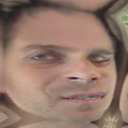

In [10]:
Image(_jpgcompression(data.train_ds[0][0].data))

In [11]:
#export
jpgcompression = TfmPixel(_jpgcompression, order=10)

## Gaussian Blur Transform

In [12]:
#export
def gaussian_kernel(size, sigma=2., dim=2, channels=3):
    # The gaussian kernel is the product of the gaussian function of each dimension.
    # kernel_size should be an odd number.
    
    kernel_size = 2*size + 1

    kernel_size = [kernel_size] * dim
    sigma = [sigma] * dim
    kernel = 1
    meshgrids = torch.meshgrid([torch.arange(size, dtype=torch.float32) for size in kernel_size])
    
    for size, std, mgrid in zip(kernel_size, sigma, meshgrids):
        mean = (size - 1) / 2
        kernel *= 1 / (std * math.sqrt(2 * math.pi)) * torch.exp(-((mgrid - mean) / (2 * std)) ** 2)

    # Make sure sum of values in gaussian kernel equals 1.
    kernel = kernel / torch.sum(kernel)

    # Reshape to depthwise convolutional weight
    kernel = kernel.view(1, 1, *kernel.size())
    kernel = kernel.repeat(channels, *[1] * (kernel.dim() - 1))

    return kernel

In [13]:
#export
def _gaussian_blur(x):
    size = random.randrange(0, 5)
    kernel = gaussian_kernel(size=size)
    kernel_size = 2*size + 1

    x = x[None,...]
    padding = int((kernel_size - 1) / 2)
    x = F.pad(x, (padding, padding, padding, padding), mode='reflect')
    x = torch.squeeze(F.conv2d(x, kernel, groups=3))

    return x

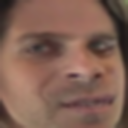

In [14]:
Image(_gaussian_blur(data.train_ds[0][0].data))

In [15]:
gaussian_blur = TfmPixel(_gaussian_blur)

## Photography Noise

Consists of 2 types of noise:
- Poisson ([implementation](https://github.com/scikit-image/scikit-image/blob/master/skimage/util/noise.py))
- Gaussian ([implementation](https://github.com/CSBDeep/CSBDeep/blob/master/csbdeep/data/transform.py))

In [43]:
torch.Tensor??

In [63]:
#export
def _photonoise(x):

    vals = len(np.unique(x))
    vals = 2 ** np.ceil(np.log2(vals))
    # Generating noise for each unique value in image.
    x = np.random.poisson(x * vals) / float(vals)
    

    std = random.uniform(0, 0.001)
    noise = np.random.normal(0,std,size=x.shape)
    x = np.maximum(0,x+noise)
    x = torch.Tensor(x)
    x.clamp_(0,1)
    
    return x

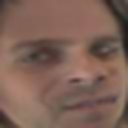

In [64]:
Image(_photonoise(data.train_ds[0][0].data))

In [66]:
photonoise = TfmPixel(_photonoise)

In [67]:
def get_data(bs,size):
    data = (src.label_from_re(lab)
           .transform(get_transforms(xtra_tfms=[jpgcompression(), gaussian_blur()]),size=size)
           .databunch(bs=bs).normalize(imagenet_stats))
    return data

In [68]:
data = get_data(bs, sz)

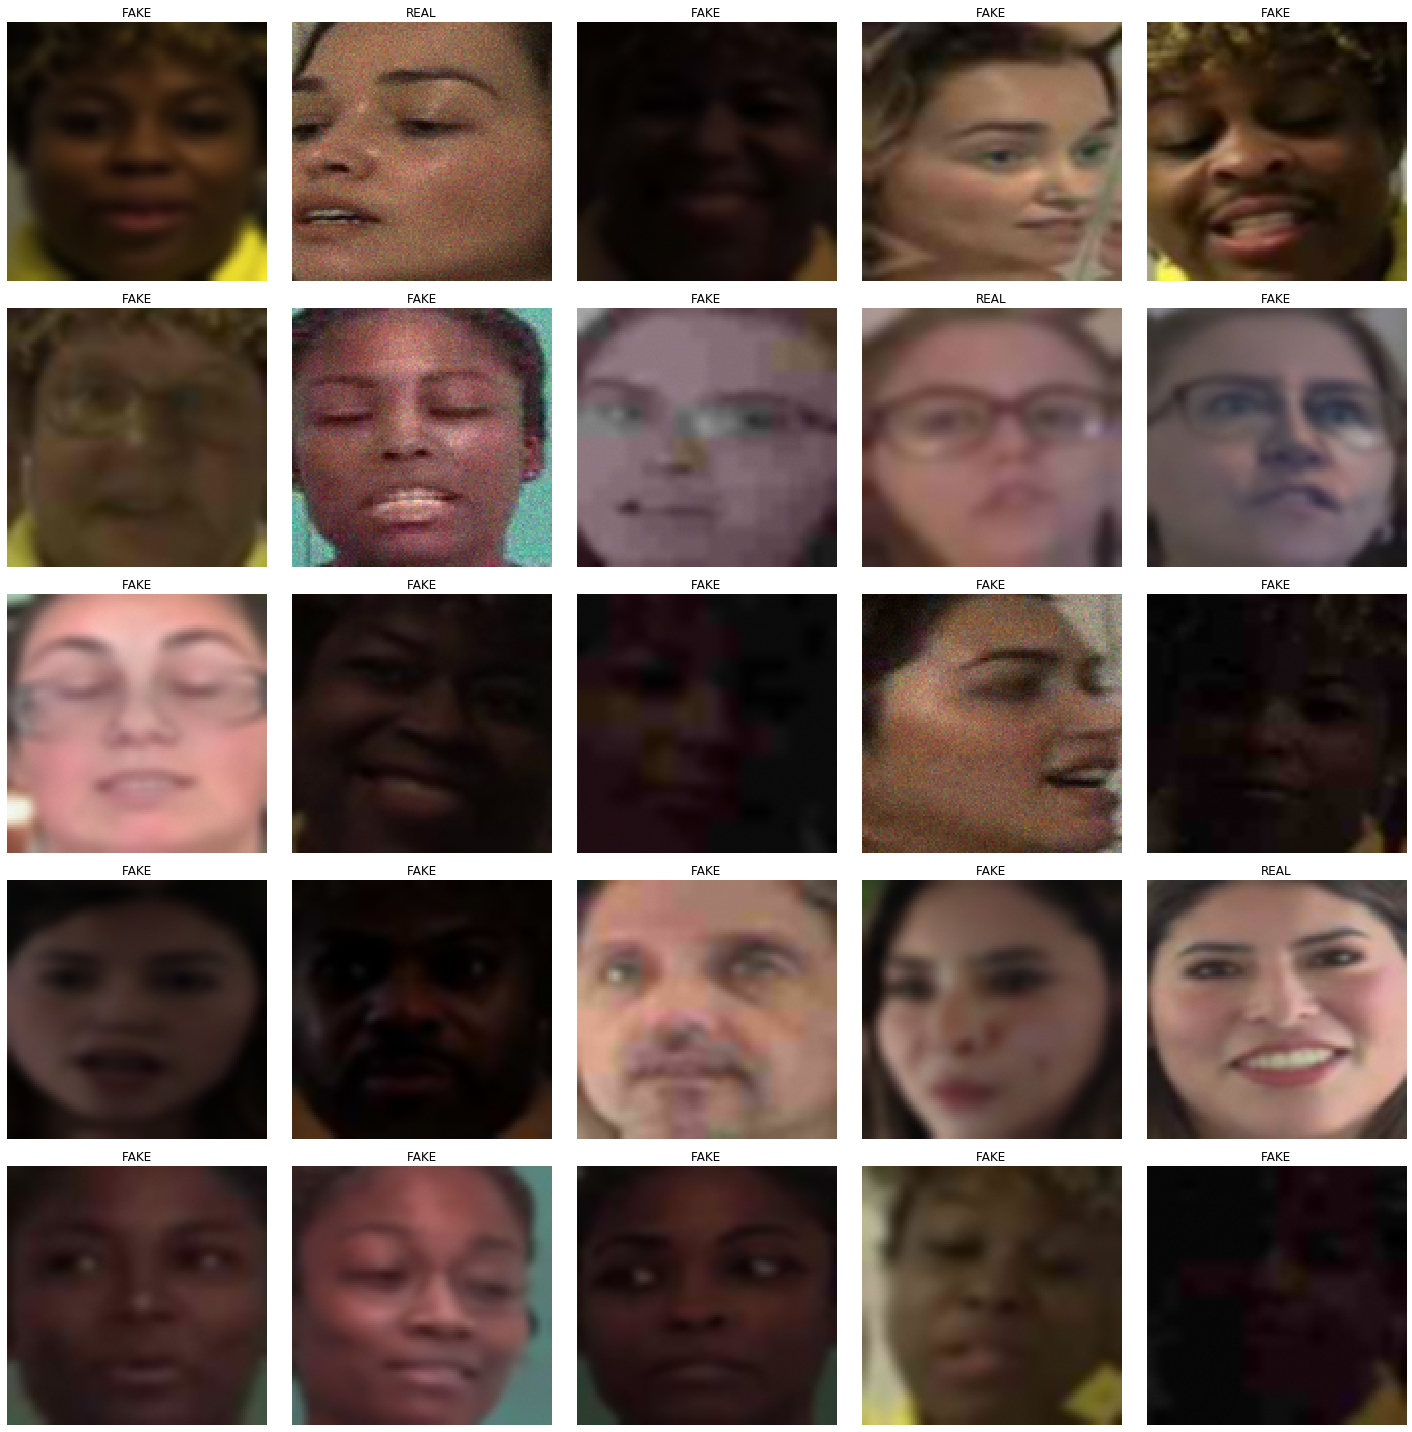

In [21]:
data.show_batch()

### Model

In [69]:
net = MesoNet()

In [70]:
learn = Learner(data, net, metrics=accuracy)

In [71]:
epochs, lr = 3, 1e-3

In [72]:
learn.fit_one_cycle(epochs, lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.532485,0.539518,0.784828,00:05
1,0.501585,0.496261,0.791724,00:04
2,0.495252,0.496814,0.791724,00:04


## Fin

In [19]:
from nbdev.export import *
notebook2script()

Converted 00_data.ipynb.
This cell doesn't have an export destination and was ignored:
e
This cell doesn't have an export destination and was ignored:
e
This cell doesn't have an export destination and was ignored:
e
This cell doesn't have an export destination and was ignored:
e
This cell doesn't have an export destination and was ignored:
e
This cell doesn't have an export destination and was ignored:
e
This cell doesn't have an export destination and was ignored:
e
This cell doesn't have an export destination and was ignored:
e
Converted 00a_video_compression.ipynb.
Converted 01_face_detection.ipynb.
Converted 01a_faces_probs_examples.ipynb.
Converted 01a_faces_probs_examples_hv.ipynb.
Converted 02_fix_luminosity.ipynb.
Converted 02a_create_faceimage_dataset.ipynb.
Converted 02bis_Create_Dataset.ipynb.
Converted 02c_faces_different_dfdc_zips.ipynb.
Converted 03_models.ipynb.
Converted 04_Baseline_Classification.ipynb.
Converted 04_Classification.ipynb.
Converted 04a_classification_v